## UNET in PyTorch

We will implement the simplified U-Net using the OxfordIIIPet dataset. The dataset contains the images of cats and dogs and the corresponging segmentation masks. The dataset is relatively small and it doesn't take too much time to train the model.

We have a `Tesla P100`. We used the Colab Pro version.

In [1]:
%%bash
nvidia-smi

Wed Aug 31 12:22:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import time

We resize the images into 256x256. You are wondering why we subtract 1 from the targets below. The mask has the values 1, 2 or 3 (foreground, background and edges). We do the transformation to have values that range between 0 and 2, as we are going to treat the values as classes in a classification task and these usually start with class 0. 

In [3]:
img_transforms = T.Compose(
    [T.Resize((256, 256)),
     T.ToTensor()]
)

target_transforms = T.Compose(
    [T.Resize((256, 256)),
     T.PILToTensor(),
     T.Lambda(lambda x: x - 1)]
)

In [4]:
from torchvision import transforms
train_dataset = OxfordIIITPet(root='../datasets', split='trainval', target_types='segmentation', transform=img_transforms, target_transform=target_transforms, download=True)
val_dataset = OxfordIIITPet(root='../datasets', split='test', target_types='segmentation', transform=img_transforms, target_transform=target_transforms, download=False)

In [5]:
BATCH_SIZE=64
NUM_WORKERS=2

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False) 

The pixel values of the masks is what we are trying to predict.

[]

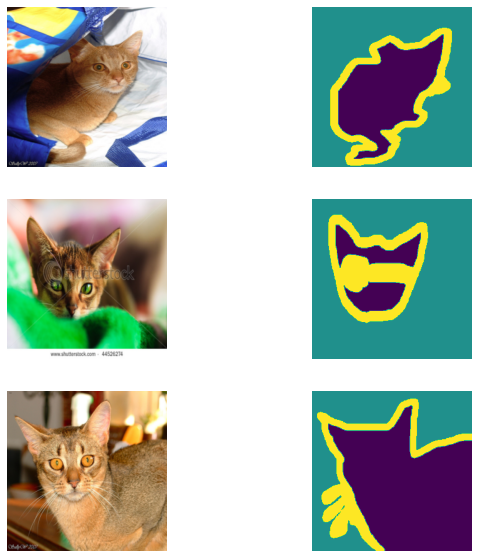

In [7]:
num_rows=3

fig = plt.figure(figsize=(10, 10))
for i in range(num_rows):
  # get image and mask from dataset
  img, mask = train_dataset[i]
  img = img.permute((1, 2, 0)).numpy()
  mask = mask.permute((1, 2, 0))[..., 0].numpy()

  # draw image
  fig.add_subplot(num_rows, 2, i*2 + 1)
  plt.imshow(img)
  plt.axis('off')

  #draw mask
  fig.add_subplot(num_rows, 2, i*2 + 2)
  plt.imshow(mask)
  plt.axis('off')

plt.plot()

We have 2 sequential paths. The downsampling path follows the usual pattern, where we reduce the resolution.

In the upsampling path we use the `ConvTranspose2d` layer to increase the resolution.

The final output is of shape 256x256x3. The 3 channels are going to contain logits that we will use in a softmax layer. The per pixel value of the mask is going to be the class with the highest probability.

In [8]:
# architecture inspired by F. Chollet book, Deep Learning in Pythond 2nd edition
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.downsampling = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),      
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
    )

    self.upsampling = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
        nn.ReLU(),
    )

    self.output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = self.downsampling(x)
    x = self.upsampling(x)
    x = self.output(x)
    return x

In [9]:
model = Model()
test_img = torch.randn(1, 3, 256, 256)
print(model(test_img).shape)

torch.Size([1, 3, 256, 256])


In [10]:
# we make sure that we train on the gpu, otherwise it is going to be too slow
assert torch.cuda.is_available()
device = torch.device('cuda:0')

In [11]:
model = Model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='min',
                                                       patience=2,
                                                       verbose=True)


In [12]:
def evaluate_performance(model, dataloader, criterion):
  model.eval()
  losses = []
  with torch.inference_mode():
    for img, target in dataloader:
      img = img.to(device)
      target = target.to(device).to(torch.long).view(-1, 256, 256)
      logits = model(img)

      loss = criterion(logits, target)
      losses.append(loss.item())
  model.train()
  return sum(losses)/len(losses)

In [13]:
def train(epochs, 
          model, 
          optim, 
          train_dataloader, 
          val_dataloader, 
          criterion, 
          scheduler=None):
  
  for epoch in range(epochs):
    start_time = time.time()
    losses = []
    for img, target in train_dataloader:
      optim.zero_grad()
      img = img.to(device)
      target = target.to(device).to(torch.long).view(-1, 256, 256)
      logits = model(img)
      loss = criterion(logits, target)
      losses.append(loss.item())
      loss.backward()
      optim.step()

    train_loss = sum(losses) / len(losses)
    val_loss = evaluate_performance(model, val_dataloader, criterion)

    end_time = time.time()
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Elapsed Time: {end_time-start_time:.2f} sec')

    if scheduler:
      scheduler.step(val_loss)

In [14]:
train(30, model, optimizer, train_dataloader, val_dataloader, criterion, scheduler)

Epoch: 1, Train Loss: 0.7916, Val Loss: 0.7141, Elapsed Time: 68.11 sec
Epoch: 2, Train Loss: 0.6383, Val Loss: 0.6827, Elapsed Time: 58.64 sec
Epoch: 3, Train Loss: 0.5593, Val Loss: 0.5414, Elapsed Time: 58.07 sec
Epoch: 4, Train Loss: 0.5110, Val Loss: 0.5044, Elapsed Time: 58.80 sec
Epoch: 5, Train Loss: 0.4776, Val Loss: 0.4658, Elapsed Time: 59.24 sec
Epoch: 6, Train Loss: 0.4558, Val Loss: 0.4563, Elapsed Time: 58.36 sec
Epoch: 7, Train Loss: 0.4374, Val Loss: 0.4725, Elapsed Time: 57.23 sec
Epoch: 8, Train Loss: 0.4194, Val Loss: 0.4814, Elapsed Time: 60.82 sec
Epoch: 9, Train Loss: 0.4059, Val Loss: 0.5387, Elapsed Time: 57.95 sec
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 10, Train Loss: 0.3681, Val Loss: 0.3756, Elapsed Time: 62.72 sec
Epoch: 11, Train Loss: 0.3545, Val Loss: 0.3626, Elapsed Time: 58.61 sec
Epoch: 12, Train Loss: 0.3485, Val Loss: 0.3632, Elapsed Time: 63.49 sec
Epoch: 13, Train Loss: 0.3433, Val Loss: 0.3566, Elapsed Time: 58.49 se

The results are not perfect, but given that we only had a couple of thousand training samples, we can live with that. Obviously you could improve the results, by using for example skip connections.

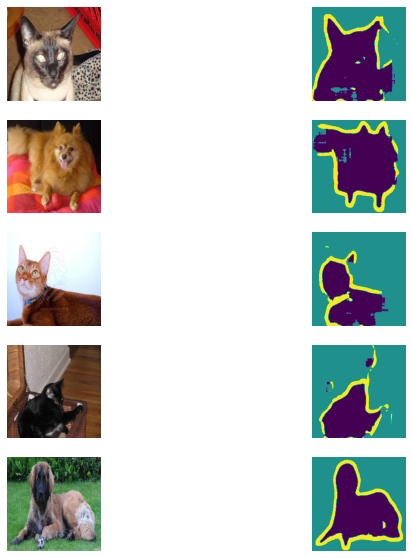

In [15]:
with torch.inference_mode():
  for images, targets in train_dataloader:
      imgages = images.to(device)
      targets = targets.to(device).to(torch.long).view(-1, 256, 256)
      logits = model(imgages)
      masks = logits.argmax(dim=1)
      
      num_rows=5

      fig = plt.figure(figsize=(10, 10))
      for i in range(num_rows):
        # get image and mask from dataset
        img, mask = imgages[i:i+1].squeeze(0), masks[i:i+1].squeeze(0)
        img = img.permute((1, 2, 0)).cpu().numpy()
        mask = mask.cpu().numpy()

        # draw image
        fig.add_subplot(num_rows, 2, i*2 + 1)
        plt.imshow(img)
        plt.axis('off')

        #draw mask
        fig.add_subplot(num_rows, 2, i*2 + 2)
        plt.imshow(mask)
        plt.axis('off')

      plt.plot()
      break
